### 경제 데이터 확인
일반적으로 알려진 경제, 금융 관련 데이터를 보고 projection을 알고자 한다. 이 노트북에서는 경제 거시지표와 금융상품의 티커 또는 내부 ID를 그대로 사용하며 기본적인 경제 과정에 대해서 말하지 않는다.

##### 데이터 로드
da.py에는 FRED와 Yahoo Finance의 데이터를 부분 획득, 업데이트하는 getdata 메서드가 있다.
* 초회 실행 시 기정의 경로에 f.csv가 있어야 한다.
* CME 선물 가격과 같이 일부 오래된 라이센스드 데이터는 직접 구해야 한다.
* FRED와 Yahoo Finance에서 자기가 원하는 series를 티커 또는 ID로 추가할 수 있다.

In [2]:
from da import *
data=getdata(save=True)
data.info()

[*********************100%***********************]  16 of 16 completed
            us02y       uj          ks          sp
date                                              
2023-07-12   4.72  140.118  2574.71997  4472.16016
2023-07-13    NaN  138.315  2591.22998  4510.04004
2023-07-14    NaN      NaN         NaN         NaN
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15901 entries, 1980-01-01 to 2023-07-14
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   adp     162 non-null    float64
 1   ahe     208 non-null    float64
 2   cb      6925 non-null   float64
 3   cci     522 non-null    float64
 4   ci      522 non-null    float64
 5   cl      5749 non-null   float64
 6   djia    2521 non-null   float64
 7   fert    511 non-null    float64
 8   fr      15899 non-null  float64
 9   fs      1541 non-null   float64
 10  hg      5744 non-null   float64
 11  hi      436 non-null    float64
 12  hs      9020 non-null   f

##### 상관성 확인
da.py에는 상관계수 heatmap을 예쁘게 그리는 wrapper 메서드 hm이 있다.
* 데이터 대부분은 비정상이며 로그정규분포를 따른다.
* ng와 같이 드물게 어떤 금융상품 가격 변동성이 크고 historic mean-reverting이 있다.

상관계수 확인는 자주 사용되지만 유의점이 있다.
* 인과관계가 아니다.
* 관계가 선형이 아니면 상관 정도가 과소평가된다.
* 상품 가격은 daily closing price이므로 상관 정도가 대체로 과소평가된다.

sp, ks, hs, us02y, fr, si의 상관성을 확인한다.

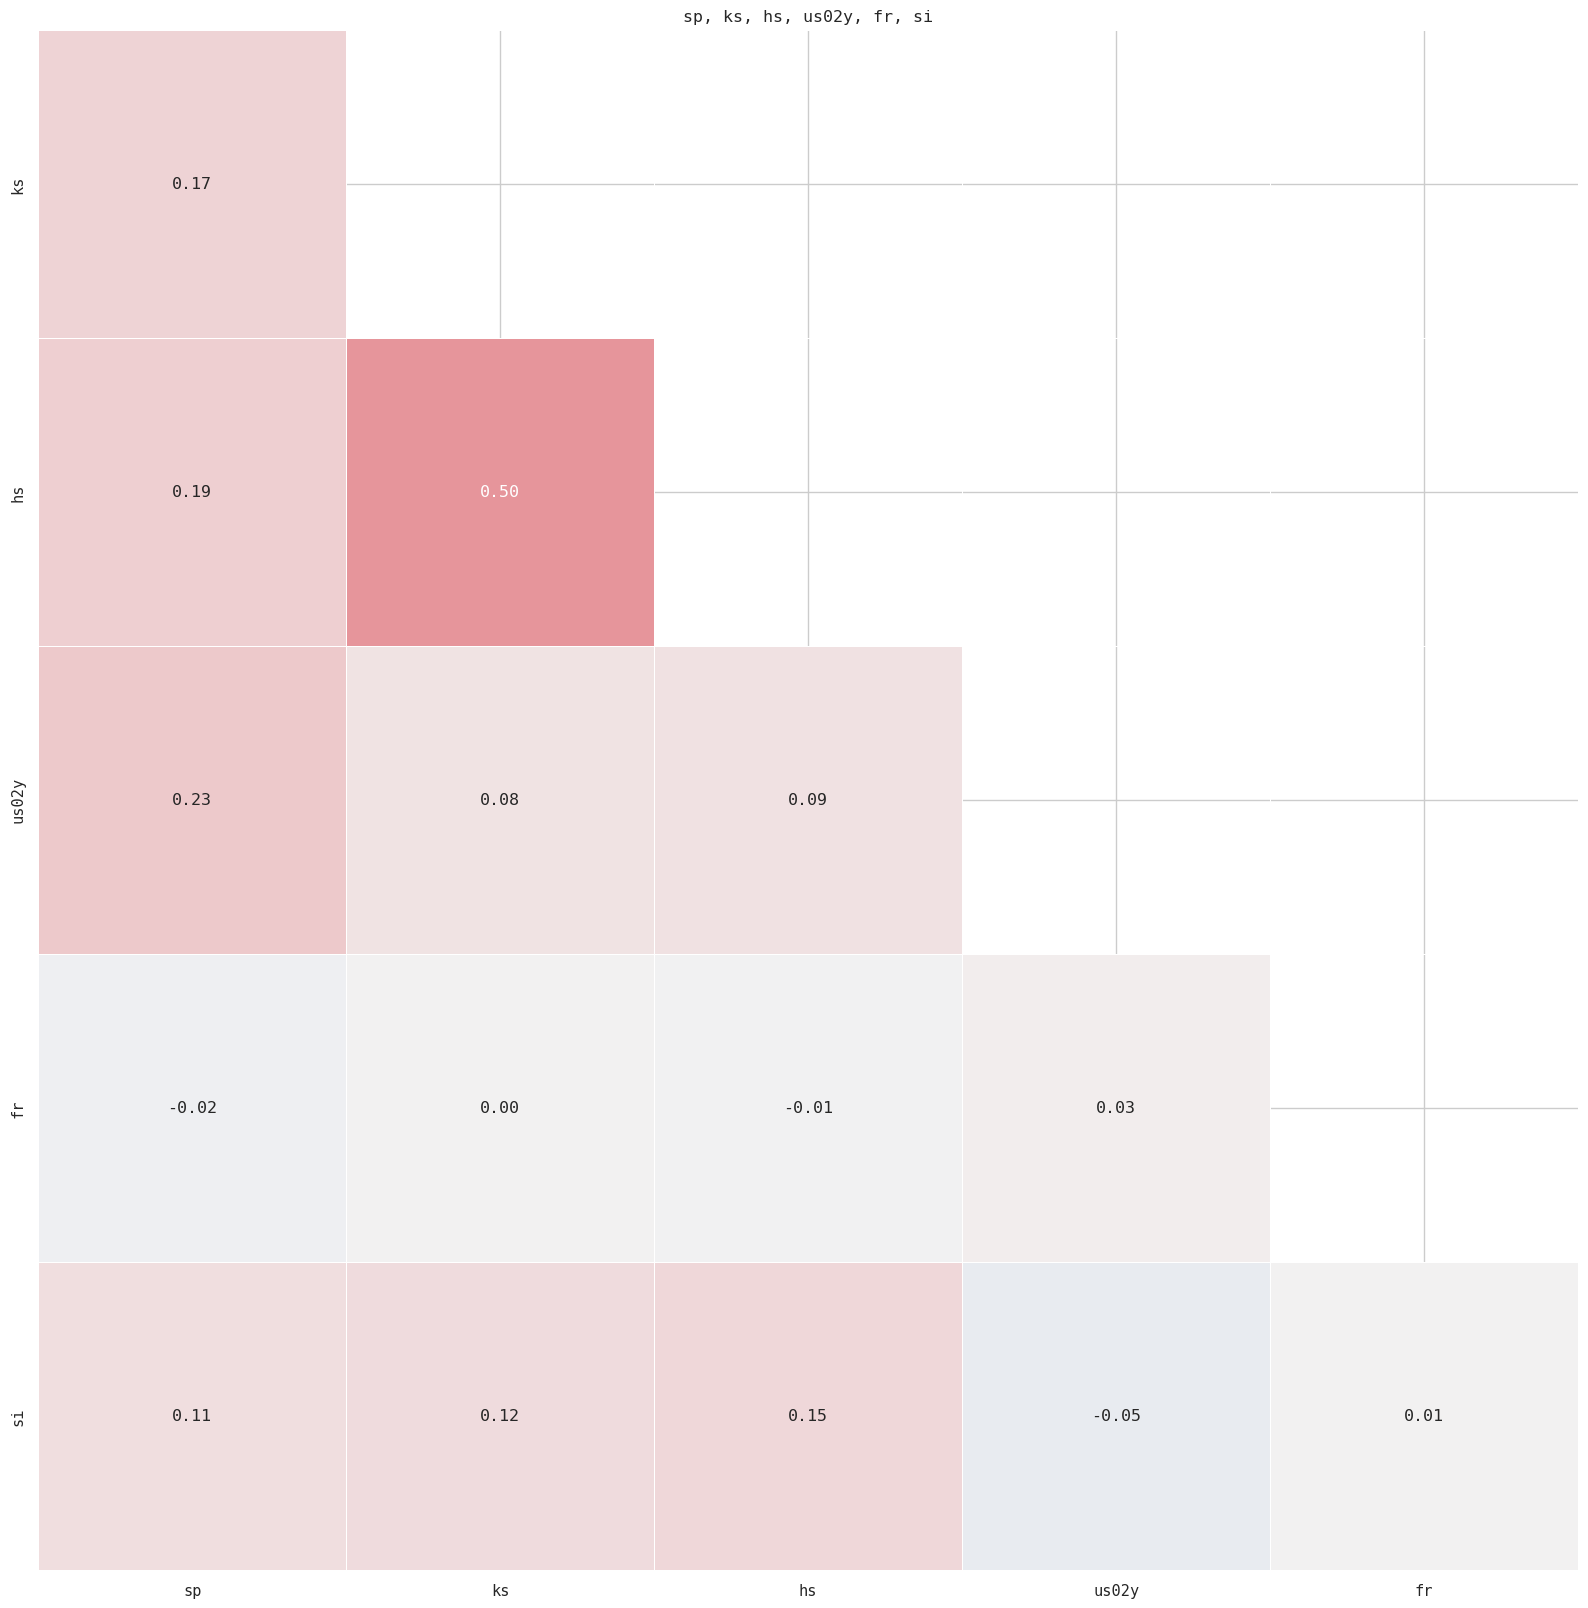

In [3]:
targets=["sp","ks","hs","us02y","fr","si"]
_data=data[targets].interpolate(limit_area="inside",limit=1).dropna(subset=["sp","ks","hs"]).pct_change()[1:]
hm(_data.corr())


* us02y와 주가지수 변화율이 동행한다.
    * 미래 GDP 증가가 곧 국채 일드를 담보한다.
    * 금리 인상은 주가지수가 높기 때문에 가능하다.
    * 구조적 문제가 발생할 때 국채 일드와 주가지수는 같이 하락한다.
* fr와 us02y의 상관계수가 크지 않다.
    * fr(SOFR)이 고시성 가격이기 때문이다.
    * Timeframe을 크게 하면 상관계수가 커질 것이다.
* sp와 hs, ks의 상관계수가 크지 않다.
    * Overlapping session이 아니기 때문이다. sp는 연결선물 가격이 아니다.

직관과 실제의 차이를 알 수 있다. 타임프레임이 커질수록 상관 정도는 다소 뚜렷해질 것이다.

#### 래깅 상관계수
야간장(유럽, 미국 세션) 주가지수 변화율이 내일 주간장(아시아 세션)에 영향을 준다고 생각한다. 위 상관계수 heatmap에서는 그 상관관계가 뚜렷하지 않다.

sp와 ks는 session time이 다르므로 daily delta 상관계수가 낮올 수 있다. sp와 ks를 예로 들어 t일 야간장이 t+1일 주간장와 상관이 있는지 본다.

(array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5]),
 array([-0.00258727,  0.01333616,  0.0260414 ,  0.09916486,  0.2994763 ,
         0.16317815,  0.01573454, -0.00514341, -0.01933834, -0.01231051,
        -0.00243458]),
 <matplotlib.lines.Line2D at 0x1f6b7154c10>)

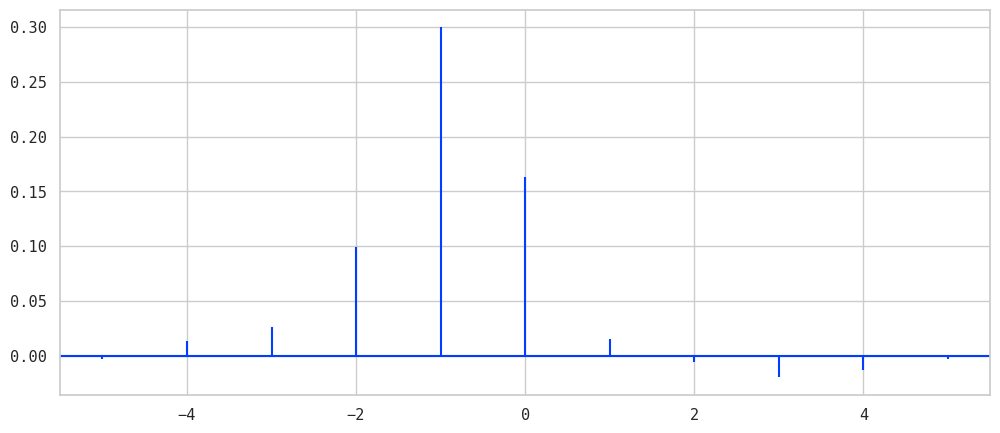

In [4]:
targets=["sp","ks"]
_data=data[targets].interpolate(limit_area="inside",limit=1).dropna().pct_change()[1:]
plt.xcorr(_data.sp,_data.ks,maxlags=5)

* ks를 -1일 shift하면 sp와 0.3의 상관계수를 갖는다.
* dji, ndx도 ks (-1)에 대해 0.3 내외의 상관계수를 갖는다.

Session time에 따라 daily delta의 상관성이 달라지며 전일 야간장 변화율이 명일 주간장 변화율에 영향함을 알았다.

#### 고용지표
고용지표는 대부분 1개월 이상 후행적이어도 발표 당일 이후 국채 일드/주가지수 추이를 결정하는 중요한 요인이다.
* 주가지수 변화율이 수개월내 도래 고용지표 변화율과 상관관계가 있다.
* GDP는 NFP의 결과이다. 두 지표의 변화율 plot의 면적이 거의 일치한다.
* 고용지표 변화율과 inflating 정도에 양의 상관관계가 있다.

고용지표에는 3가지가 있다.
* unrate: 실업률. 잘 변하지 않지만 대표성이 높다.
* nfp: Nonfarm Payrolls. 월간 새로 생성된 일자리 개수이다.
* icsa: Inicial Claims. 주간 실업수당 청구건수이다. 1주일밖에 후행적이지 않다.

먼저 고용지표 변화율을 그려 본다.

<Axes: xlabel='date'>

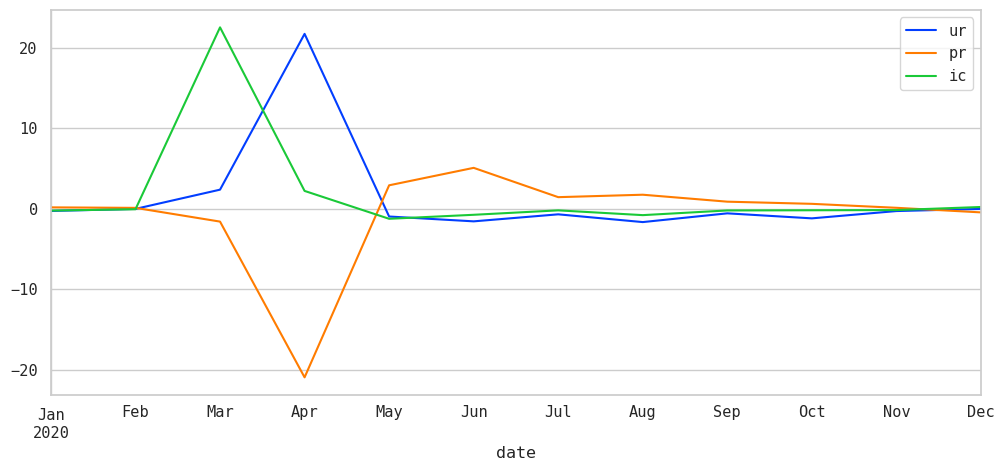

In [5]:
targets=["ur","pr","ic"]
_data=data[targets].resample("m").mean().pct_change()[1:]
_data=scipy.stats.zscore(_data,nan_policy="omit")
_data.loc["2020"].plot()

* ICSA가 상승하면 NFP가 감소하고 UNRATE가 증가한다.
    * 당월 후반부로 갈수록 ICSA 집적되면 전월 또는 당월 NFP 변화율의 guiding light가 된다.
* 이런 현상의 발생 순서가 항상 있지 않다.
    * 2020년은 타격 받은 업종이 서비스업이기 때문일 것이다.

ICSA, NFP, UNRATE의 특성을 알았다. 이제 가장 NFP와 주가지수의 관계를 본다.

<Axes: xlabel='date'>

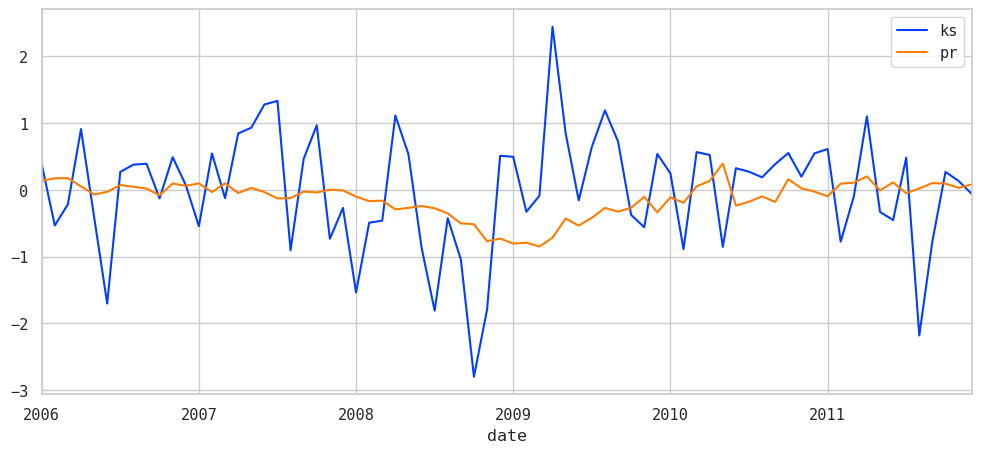

In [6]:
targets=["ks","pr"]
_data=data[targets].resample("m").mean().pct_change().dropna()
_data=scipy.stats.zscore(_data)
_data.loc["2006":"2011"].plot()

* 주가지수는 가장 선행적인 거시지표로서, 당월 발표된 전월 NFP의 정도를 이전에 이미 반영한다.
* 실제로 주가지수/NFP 변화율에는 약한 음의 상관관계가 있다.

#### 가격지표
가격지표는 1개월 이상 후행적이어도 국채 일드/주가지수 추이를 결정하는 가장 중요한 요인이다. 유동성 주입, 가격 상승, 일자리 증가, 주가지수 상승이 같은 맥락에 있음을 안다면 가격지표의 중요성을 바로 알 수 있다.
* CPI, PCE와 volatility가 높은 원자재 부문을 뺀 core가 있다.
* 흔히 말하는 2% inflation target이란 Core PCE MoM 2%이다.
    * PCE 중요하지만 CPI 이후 공개되어 CPI 기반 예측이 쉽다.
* PPI도 CPI 이후 공개되어 중요하지 않다.

가격지표 및 그와 상관관계가 있을 것 같은 몇 가지 지표를 그려 본다.

<Axes: xlabel='date'>

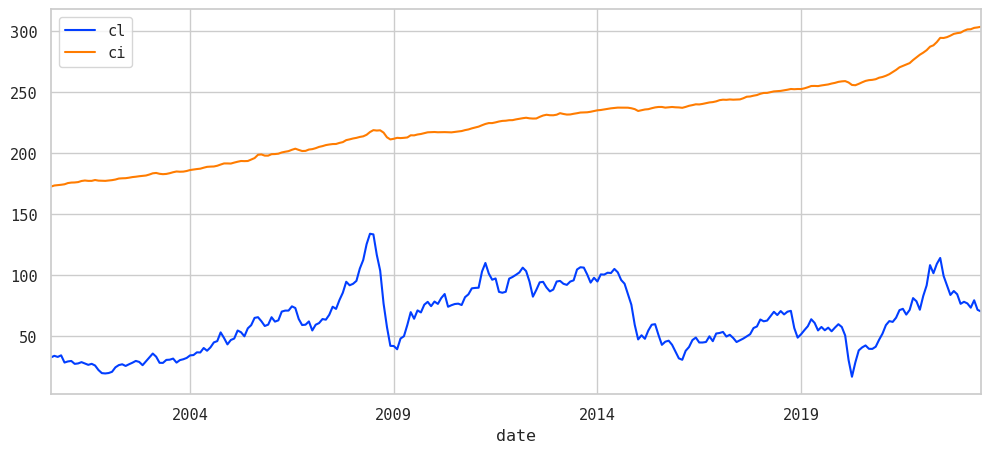

In [7]:
data[["cl","ci"]].resample("m").mean().dropna().plot()

* 특별한 처리 없이 그려도 유가와 가격지표의 상관관계가 나온다.
* 원유/천연가스 선물 가격만 집적해도 헤드라인 CPI는 예측이 쉽다.

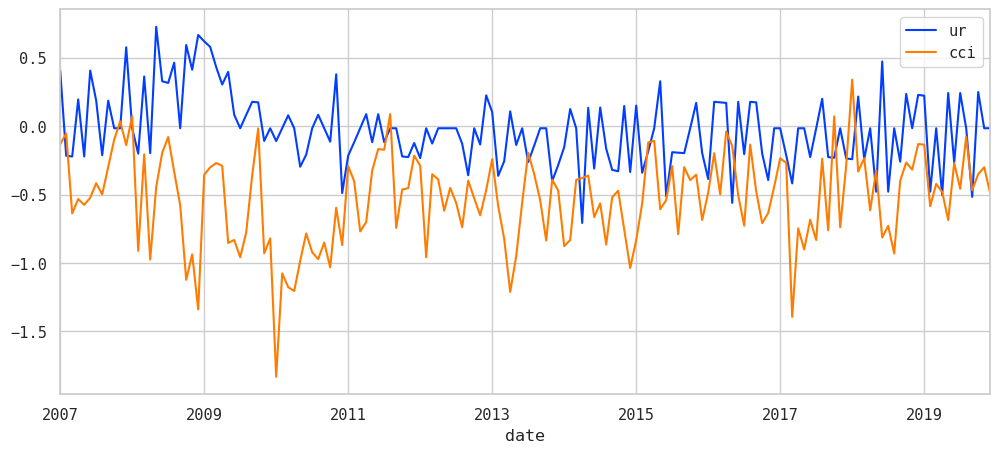

(array([-3, -2, -1,  0,  1,  2,  3]),
 array([ 0.01757248,  0.04026014, -0.03636296, -0.15187164, -0.08281003,
        -0.03715991,  0.04006506]),
 <matplotlib.lines.Line2D at 0x1f6b96638d0>)

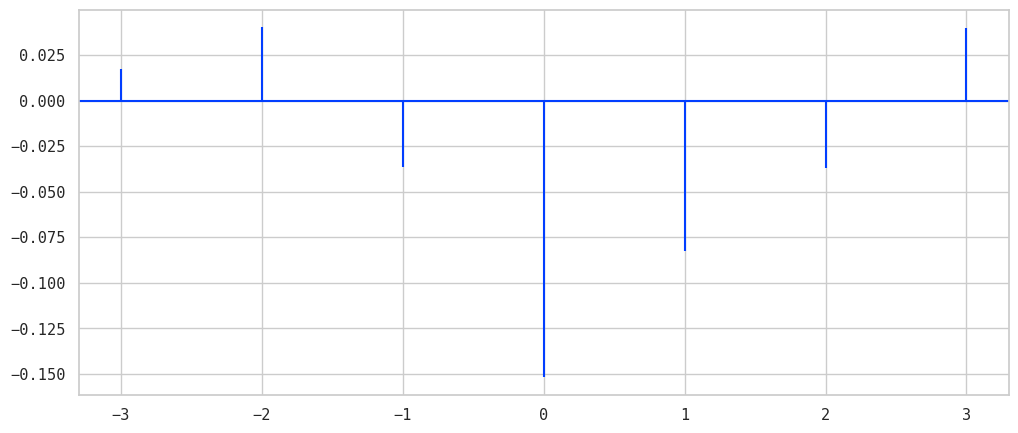

In [8]:
_data=scipy.stats.zscore(data[["ur","cci"]].resample("M").mean().pct_change(fill_method=None).dropna(how="all"),nan_policy="omit")
_data.loc["2007":"2019"].plot(),plt.show()
plt.xcorr(_data.cci,_data.ur,maxlags=3)

* cci와 ur에는 전기간에 걸쳐 약한 음의 상관관계가 있고 정도는 context에 따라 다름
    * t-1 실업률 변화율이 t 근원 CPI 변화율에 음의 영향
    * 맥락에 따라 상관 정도가 커짐: 2022년 이후 0.3~
* 가격지표는 미래 inflating 정도를 조절하는 요인
    * 가격지표가 높게 나오면 모든 명목 가격이 deflating

#### 비정상성, 랜덤워크
데이터의 대부분, 특히 상품 가격은 정상성이 없다. 나스닥 일일 종가는 정상성이 없다. t일의 종가는 t-1일의 종가의 어느 정도에 머무른다. 나스닥 일일 종가와 코스피 일일 종가의 상관계수는 1에 가깝다. 모든 상품 가격은 시간의 흐름에 따라 유동성이 주입되므로 당연히 동시 상승한다. '사람들이 나이를 먹어가면 주가지수가 상승한다'와 같은 맥락이다.

정상성 여부는 ADF나 자기상관계수를 구해서 알 수 있다. 그려봐도 대충 알 수 있다.

<Axes: xlabel='date'>

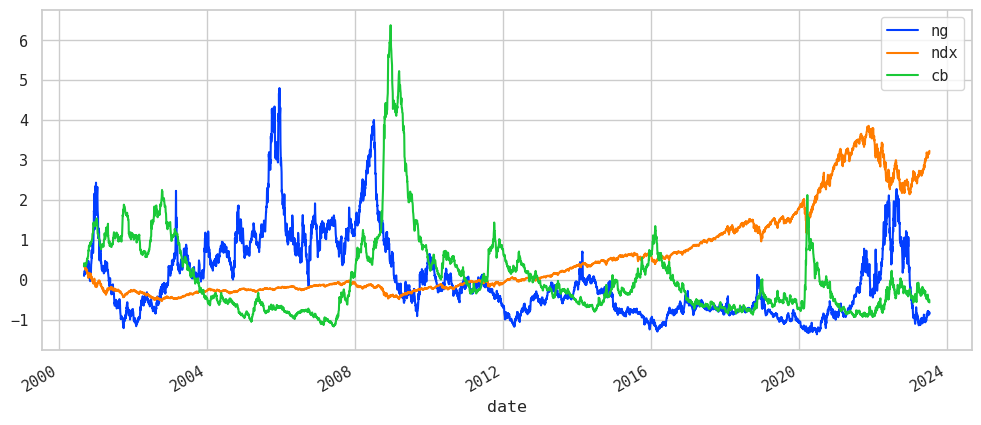

In [9]:
scipy.stats.zscore(data[["ng","ndx","cb"]],nan_policy="omit").dropna().plot()

* ng는 천연가스 연결선물(spot) 가격이다. 변동성이 크고 평균 회귀 경향이 있어 정상성이 있어 보인다.
* ndx는 나스닥 일일 종가이다. 정상성이 없다.
* cb는 회사채 일드 스프레드이다. ng보다도 정상성이 있어 보인다.

비정상적 데이터는 전체 기간의 평균이 의미가 없다. ndx가 전체 기간의 평균으로 돌아가는 때가 올까? ng는 전체 기간의 평균이 의미가 있다.

<Axes: xlabel='date'>

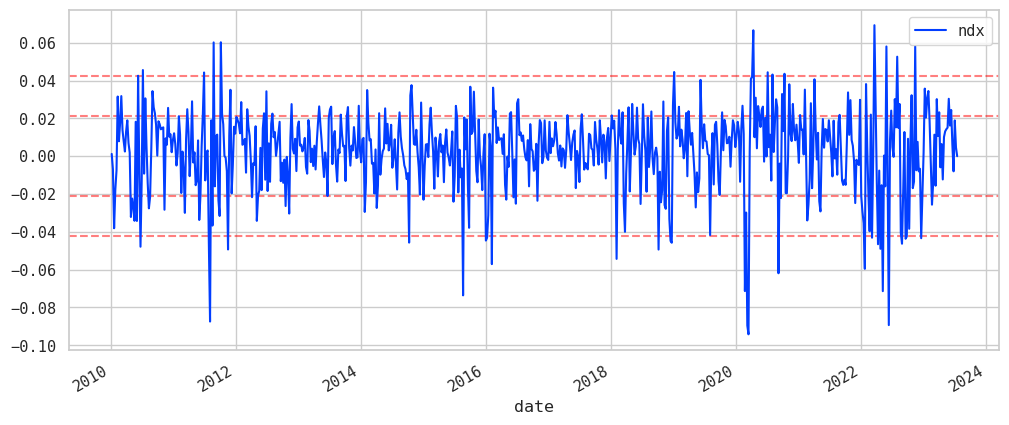

In [41]:
_data=data[["ndx"]].loc["2010":].resample("7d").mean().pct_change().dropna()
fg,ax=plt.subplots()
[ax.axhline(y=_data.ndx.std()*q,linestyle="dashed",alpha=.5,color="red") for q in (-2,-1,1,2)]
_data.plot(ax=ax)

* ndx 등 상품 가격은 랜덤워크이다.
* 변화율이 큰 부분에서 price action이 발생했다.
* 도래 지점까지 nominal price 변화 slope 특성을 규정하는 '맥락 인자'가 있다.
    * 가격지표, 고용지표, 소비판매 증가율 등
    * 지표가 얼마나 많이 예상을 벗어났는지
* 빨간 선은 daily delta의 2010년 이후 기준 1, 2 시그마이다.

비정상적이고 랜덤워크를 따르는 가격을 두고 기술적으로 레벨을 예측하는 것은 스타벅스를 방문하는 남자의 키가 점진적으로 길어졌다가 짧아질 것 같다고 생각하고 차기 방문자의 키를 정확히 예상하려는 것과 같다. (사실 초고빈도매매에서 daily delta 또는 nominal price의 std를 활용하는 true range 방법이 생각보다는 선방하나, 지속될 수 없다.) 가정된 실제 시장 미시적 행위에서 따라서 기술적 분석은 아무런 의미가 없다. LSTM와 같은 기계학습의 근간이 수십년 전 태동했다는 점을 생각하면, 거시지표와 같은 경제적 맥락과 그 학문적 정의에 비해 기술적 분석은 미신인 것이다.

### 근거와 출처
Ben S. Bernanke, Bernanke's Lecture Serie, https://www.youtube.com/watch?v=E3fFg8XIS0k, 2012.  
SAS를 이용한 현대통계학 2e, 최병선, 2003.  
통계학 3e, 류근관, 2016.  
Eric C. Engstrom et al., The Near-Term Forward Yield Spread as a Leading Indicator: A Less Distorted Mirror, 2018.  
H. Clark et al., How Stable Is China’s Growth? Shedding Light on Sparse Data, 2020.  
Kevin L. Kliessen, Measuring Financial Market Stress, 2010.  
U.S. Bureau of Labor Statistics, Producer Price Index by Commodity: All Commodities [PPIACO], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/PPIACO, December 11, 2022.  
U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items in U.S. City Average [CPIAUCSL], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CPIAUCSL, December 11, 2022.  
U.S. Bureau of Economic Analysis, Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index) [PCEPILFE], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/PCEPILFE, December 11, 2022.  
U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items in U.S. City Average [CPIAUCSL], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CPIAUCSL, December 11, 2022.  
U.S. Employment and Training Administration, Initial Claims [ICSA], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/ICSA, December 11, 2022.  
Federal Reserve Bank of St. Louis, 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity [T10Y3M], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/T10Y3M, December 11, 2022.  
Board of Governors of the Federal Reserve System (US), Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis, Inflation-Indexed [DFII10], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DFII10, December 11, 2022.  
Board of Governors of the Federal Reserve System (US), Federal Funds Effective Rate [DFF], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DFF, December 11, 2022.  
S&P Dow Jones Indices LLC, S&P/Case-Shiller U.S. National Home Price Index [CSUSHPISA], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CSUSHPISA, December 11, 2022.  
Ice Data Indices, LLC, ICE BofA US High Yield Index Option-Adjusted Spread [BAMLH0A0HYM2], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/BAMLH0A0HYM2, December 11, 2022.  
Ministry of Finance, 10-year Inflation-Indexed Bonds, https://www.mof.go.jp/english/policy/jgbs/topics/bond/10year_inflation/index.htm, December 11, 2022.  
Yahoo! API T&C, https://legal.yahoo.com/us/en/yahoo/terms/product-atos/apiforydn/index.html